# codecentric.AI Bootcamp - NLP

*Hallo und herzlich willkommen zum codecentric.AI bootcamp!*

Im Tutorial haben wir bereits eine Anwendung von NLP vorgestellt. Nun wollen wir Dich in einem
praktischen Teil dazu einladen, selbst ein paar typische NLP-Techniken auszuprobieren und zu implementieren. Dabei erfährst Du,

1. wie elegant sich N-Gramme in Python extrahieren lassen,
2. wieviel Stopp-Wörter Politiker verwenden,
3. wie man in wenigen Zeilen "Wer fällt aus der Reihe?" programmiert,
4. was sich hinter dem tf-idf-Maß verbirgt und wie man scikit-learn-Transformer verwendet.

Damit es gleich losgehen kann, benötigen wir die folgenden Bibliotheken.

*Viel Spaß!*

In [26]:
import os
import numpy as np
import pandas as pd
import gensim

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

## Aufgabe 1: Von einzelnen Wörtern zu Wortgruppen

Als erste Möglichkeit, einen Text zu analysieren, haben wir uns dessen *einzelne Wörter* beziehungsweise dessen bag of words angeschaut. Oft ist es hilfreich, zusätzlich *Wortgruppen* anzuschauen, etwa alle auftretenden Wortpaare. Für den Beispielsatz

> "Fischers Fritz fischt frische Fische"

wären das also

> "Fischers Fritz", "Fritz fischt", "fischt frische", "frische Fische".

Allgemein bezeichnet man als [N-Gramm](https://de.wikipedia.org/wiki/N-Gramm) ein Tupel von N aufeinander folgenden Token. Ist N=2 wie im Beispiel, so spricht man von _Bigrammen_.

### (a)  Bigramme extrahieren

Schreibe eine Funktion `bigrams`, die eine Liste `words` von Wörtern als Eingabe nimmt und die Menge aller auftretenden Bigramme zurückgibt. Tipp: Verwende `zip`!

In [ ]:
def bigrams(words):
    return set(zip(words[:-1], words[1:]))

In [ ]:
WORDS = ["Fischers", "Fritz", "fischt", "frische", "Fische"]
bigrams(WORDS)

### (b) N-Gramme extrahieren

Schreibe nun eine Funktion `ngrams`, die eine Liste `words` von Wörtern und eine Zahl `n` erwartet und die Menge aller n-Gramme zurückgibt. Tipp: mit `zip(*iters)` kann man `zip` auf eine ganze Liste `iters` von `Iterable`s anwenden. 

In [ ]:
def ngrams(words, n):
    l = len(words) - n + 1
    return set(zip(*[words[i:l + i] for i in range(0,n)]))

In [ ]:
ngrams(WORDS,3)

## Aufgabe 2: Wer verwendet die meisten Stopp-Wörter?

Ein üblicher Arbeitsschritt bei NLP ist die Entfernung sogenannter [Stopp-Wörter](https://de.wikipedia.org/wiki/Stoppwort), die häufig auftreten, aber für den Anwendungsfall keine wesentliche Informationen beinhalten. Wir testen, wieviel Stopp-Wörter in den Reden auftauchen, die wir im Tutorial klassifiziert hatten. Dazu lesen wir die Reden nochmal ein:

In [ ]:
DATA_PATH = "data"
DATASET = "Bundesregierung.xml"
ANALYSIS_FILE = DATASET.replace(".xml", ".pickle")
ANALYSIS_PATH = os.path.join(DATA_PATH, ANALYSIS_FILE)

df = pd.read_pickle(ANALYSIS_PATH)

### (a) Stopp-Wörter filtern 

Eine Liste von 231 Stopp-Wörtern ist in [NLTK](https://www.nltk.org/) enthalten. Wir haben diese Stopp-Wörter zeilenweise in der Datei `data/stopwords_nltk.txt` abgespeichert. Schreibe

- eine Funktion `read_stopwords`, die die Liste der Stopp-Wörter einliest und als Menge zurückgibt,
- eine Funktion  `filter_words`, die aus einer Liste `words` alle Wörter ausfiltert, die in `stopwords` enthalten sind, und die bereinigte Liste zurückgibt. 

Tips:

- Öffne die Datei der Stopwörter mit der Option `encoding="utf-8"`.
- Benutze gegebenenfalls die Methode [rstrip](https://docs.python.org/3/library/stdtypes.html), um Zeilenumbrüche von eingelesenen Strings zu entfernen.
- `filter_words` sollte ein Einzeiler sein.

In [ ]:
STOPWORDS_FILE = "stopwords_nltk.txt"
STOPWORDS_PATH = os.path.join(DATA_PATH, STOPWORDS_FILE)

def read_stopwords(filename = STOPWORDS_PATH):
    with open(filename, mode="r", encoding="utf-8") as file:
        words = set([word.rstrip("\n") for word in file])
    return words

def filter_words(words, stopwords):
    return [w for w in words if w not in stopwords]

Teste Deine Funktionen wie folgt:

In [ ]:
EXAMPLE = ["Das", "ist", "ein", "ganz", "und", "gar", "normaler", "Satz", "mit", "vielen", "Wörtern"]
stopwords = read_stopwords()
filter_words(EXAMPLE, stopwords)

### (b) Anwendung auf die Reden

Füge nun dem pandas-DataFrame `df` eine Spalte `filtered_tokens` hinzu, die für jede Rede die Liste der Token enthält, aus denen die Stopp-Wörter entfernt wurden.


In [ ]:
df["filtered_tokens"] = df["tokens"].map(lambda t: filter_words(t, stopwords))
df.head()

Füge als Nächstes `df` eine Spalte `stop_percentage` hinzu, die für jede Rede angibt, wieviel Prozent der Rede Stopp-Wörter waren.

In [ ]:
df["stop_percentage"] = (1- df["filtered_tokens"].map(len) / df["tokens"].map(len)) * 100 
df.head()

### (d) Stopp-Wort-Anteile visualisieren

Plotte abschließend den prozentualen Anteil an Stopp-Wörtern in den Redern nach Politikern gruppiert in einem geeigneten. Wodurch fallen Kanzler auf?

Tipp: Verwende [kategorielle Plot-Funktionen](https://seaborn.pydata.org/tutorial/categorical.html) von seaborn oder schau im Tutorial nach.

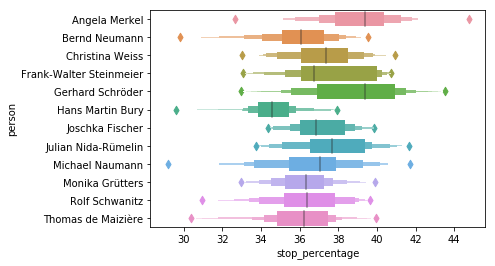

In [25]:
_ = sns.boxenplot(y="person", x="stop_percentage", data=df)

## Aufgabe 3: Wer fällt aus der Reihe?

Word embeddings kann man nicht nur für ernsthaftes NLP verwenden, sondern auch, um Spaß zu haben. Im Tutorial hatten wir schon ein kleines Tabu-Spiel programmiert. Nun wollen wir in wenigen Zeilen eine Funktion `find_the_odd` schreiben, die aus einer Liste von Wörtern den Ausreißer herausfindet &mdash; das Wort, das aus der Reihe fällt. Zum Beispiel also

> Fruehling, Sommer, Abend, Herbst
> => Abend


Dazu benötigen wir wieder die Wortvektoren aus der [Arbeit](https://devmount.github.io/GermanWordEmbeddings/) von [Andreas Müller](https://github.com/devmount).

In [ ]:
WV_PATH = "data/german.model"

w2v = gensim.models.KeyedVectors.load_word2vec_format(WV_PATH, binary=True)

### (a) Ähnlichkeitsmatrix berechnen

Die Wortvektoren sind nun in als gensim-`KeyedVectors`-Objekt `w2v` verfügbar. Die Methode `similarity` berechnet zu gegebenen Wörtern nun deren [Cosinus-Ähnlichkeit](https://de.wikipedia.org/wiki/Kosinus-%C3%84hnlichkeit): 0 heißt keine Ähnlichkeit, 1 heißt Übereinstimmung.

In [ ]:
w2v.similarity("Mensch", "Maschine")

Schreibe nun eine Funktion `similarity_matrix`, die eine Liste `words` von Wörtern als Eingabe nimmt und ein 2-dimensionales numpy-Array zurückliefert, dessen Eintrag an der Stelle `[i,j]` die Cosinus-Ähnlichkeit zwischen den Wörtern `words[i]` und `words[j]` ist. 

In [ ]:
def similarity_matrix(words):
    mat = np.zeros((len(words), len(words)))                   
    for (i,v) in enumerate(words):
        for (j,w) in enumerate(words):
            mat[i,j] = w2v.similarity(v,w)
    return mat

Mit Hilfe der numpy-Funktion [asarray](https://docs.scipy.org/doc/numpy/reference/generated/numpy.asarray.html) und List-Komprehensionen geht das in zwei Zeilen:

In [ ]:
def similarity_matrix(words):
    sims = [[[w2v.similarity(w1, w2)] for w1 in words] for w2 in words]
    return np.asarray(sims)

### (b) Ausreißer finden 

Um den Ausreißer in einer Liste `words` von Wörtern zu finden, können wir nun die Matrix `similarity_matrix(words)` nehmen und die Einträge jeder Zeile aufsummieren: die Zeile mit der kleinsten Summe entspricht dem Ausreißer. Schreibe eine Funktion `find_the_odd`, welche dies umsetzt. Hilfreich sind dabei die numpy-Funktionen [np.sum](https://docs.scipy.org/doc/numpy/reference/generated/numpy.sum.html) und [np.argmin](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmin.html).

In [ ]:
def find_the_odd(words):
    return words[np.argmin(np.sum(similarity_matrix(words), axis=0))]

### (c) Probier es aus! 

Teste nun Deine Funktion an folgenden Beispielen und denk Dir selber welche aus! Beachte dabei, dass alle Wörter groß geschrieben und die Umlaute `ä`, `ö`, `ü` sowie `ß` als `ae`, `oe`, `ue` beziehungsweise `ss`umgeschrieben werden müssen. 

In [ ]:
ODDS = [["Fruehling", "Sommer", "Abend", "Herbst"],
        ["Fruehstueck", "Oma", "Abendbrot", "Mittagessen"],
        ["Rot", "Gruen", "Blau", "Maler"],
        ["Hund", "Mensch", "Hase", "Katze"],
        ["Tochter", "Mutter", "Grossmutter", "Cousine"]
    ]

for odd_set in ODDS:
    print(", ".join(odd_set), " => ", find_the_odd(odd_set))

## Aufgabe 4

### Intro tf-idf
Im Tutorial haben wir bereits *bag of words* und *count* kennengelernt, zwei statistische Darstellungen der aus den Reden gewonnenen Features.
Hier lernen wir weitere wichtige Darstellungen kennen:
- Die *Vorkommenshäufigkeit*, welche im Englischen *term frequency* (*tf*) genannt wird, misst die "Wichtigkeit" eines Terms im enthaltenden Dokument.
Bemerke jedoch, dass es häufige aber "unwichtige" Terme wie z.B. die Artikel _der_, _die_ und _das_ gibt.
Um solche Effekte zu kontrollieren wird ein weiteres Maß verwendet.
- Die *inverse Dokumentvorkommenshäufigkeit*, englisch *inverse document frequency* (*idf*), misst die Spezifischheit eines Terms in der gesamten zugrunde liegenden Dokumentmenge:
Je häufiger, desto "unwichtiger".

Beide werden kombiniert, siehe Wikipedia-Artikel zu [tf-idf](https://de.wikipedia.org/wiki/Tf-idf-Ma%C3%9F).
Zusammen gilt ein Term einer Rede also als wichtig, wenn er in der Rede oft behandelt wird und gleichzeitig kein sonst üblicher Begriff ist.

### Aufwärmen

In der Übung berechnen wir tf-idf-Werte für die Lemma-Features der Reden.
Unser Ziel ist also eine Matrix `tfidf` der Dimension `numSpeeches x numLemmata`, welche für jedes Lemma jeder Rede den tf-idf-Wert in der entsprechenden Zelle speichert.
Dafür greifen wir auf eine fertige tf-idf-Implementierung aus der [scikit-learn](https://scikit-learn.org/stable/)-Bibliothek zurück.
Bei der Vervollständigung des folgenden Codes kann ggf. die Doku helfen.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.____ import TfidfVectorizer

# Vorbereitung der Daten
all_lemmas = list(set.union(*list(map(set, df.lemmata))))
concatenated_lemma_lists = df.lemmata.apply(lambda lemma_list: str.join(" ", lemma_list))

vectorizer = TfidfVectorizer(vocabulary = all_lemmas)
tfidf = vectorizer.fit_transform(concatenated_lemma_lists)
#tfidf = TfidfVectorizer().fit_transform(____)

assert all_lemmas == vectorizer.get_feature_names() # korrekte Verwendung des Vokabulars
assert (len(df.lemmata), len(all_lemmas)) == tfidf.shape # korrekte Matrixdimensionen

Jetzt können wir uns die wichtigsten Terme einer beliebigen Rede anschauen.

In [ ]:
REDE = 10
termsAndTfidfs = list(zip(df.lemmata[REDE], tfidf.toarray()[REDE]))
termsAndTfidfs.sort(reverse = True, key = lambda termAndTfidf: termAndTfidf[1])
termsAndTfidfs[:25]

### Trainieren

Nun möchten wir mit den gewonnenen tf-idf-Daten einen Bayesschen Klassifizierer trainieren.
Die wesentlichen Schritte sind wie immer:
1. Zerlegung in Trainings- und Testdaten.
2. Das eigentliche Training.
3. Testdaten verwenden, um die Qualität des Trainings zu beurteilen.

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB

# 1.
# Zur Erinnerung: Die Namen der Redner*Innen sind in df["@person"] gespeichert
trainSpeeches, testSpeeches, trainSpeakers, testSpeakers = train_test_split(tfidf, df["@person"], test_size = 0.3, random_state = 42)
#trainSpeeches, testSpeeches, trainSpeakers, testSpeakers = ____(____, ____, test_size = 0.3, random_state = 42)

# 2.
classifier = MultinomialNB()
classifier.fit(trainSpeeches, trainSpeakers)
#classifier.____(____, ____)

# 3.
predictedSpeakers = classifier.predict(testSpeeches)
#predictedSpeakers = classifier.____(____)
accuracy = np.mean(testSpeakers == predictedSpeakers)
speakers = np.unique(testSpeakers)
speakers = df["@person"].groupby(lambda )
confusionMatrix = confusion_matrix(testSpeakers, predictedSpeakers, labels=speakers)
speakers

### Ergebnisse bewerten

Es stellt sich heraus, dass keine zufriedenstellende Qualität erreicht wird.
Die Accuracy ist schlecht.
Im Plot der Confusion-Matrix zeigt sich, dass viele Reden fälschlicherweise Bernd Neumann und Monika Grütters zugeordnet wurden, viele Reden Angela Merkels wurden Gerhard Schröder zugeordnet.

In [ ]:
print("Accuracy:", accuracy)
sns.heatmap(confusionMatrix, xticklabels=speakers, yticklabels=speakers)

Ist dieses Ergebnis belastbar?
Nein, denn bei der erreichten Qualität kann es sich natürlich um einen Ausreißer handeln.
Schließlich haben wir die Trainingsdaten zufällig gewählt und eine gute Wahl ist nicht garantiert.

Überzeuge Dich in einer freien Übung davon, dass auch für andere Trainingssets keine ausreichende Qualität erzielt wird.

In [ ]:
# freie Übung
# teste den classifier für viele verschiedene Zerlegungen und analysiere die Ergebnisse (z.B. durch Mittelung der Accuracys)